第一步：地點選擇原因視覺化

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# 載入資料
data = pd.read_csv('/Users/yulin/Desktop/人流/人工智慧/city_challengedata.csv')

In [18]:
# 移除缺失資料點
data = data[(data['x'] != 999) & (data['y'] != 999)]

# 確認資料結構
data.info()

# 統計每個網格 (x, y) 出現的資料筆數
grid_counts = data.groupby(['x', 'y']).size().reset_index(name='count')

# 找出資料筆數最多的前三個網格
top_grids = grid_counts.nlargest(3, 'count')

# 顯示結果
print(top_grids)


<class 'pandas.core.frame.DataFrame'>
Index: 23913082 entries, 0 to 23913081
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 1.1 GB
        x   y   count
11877  80  95  122068
11874  80  92  118145
11875  80  93  113517


/var/folders/n2/fm6sdglj7ys6t3b8yg12ybwr0000gn/T/ipykernel_15444/1917452103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hours'] = filtered_data['d'] * 24 + (filtered_data['t'] // 2)


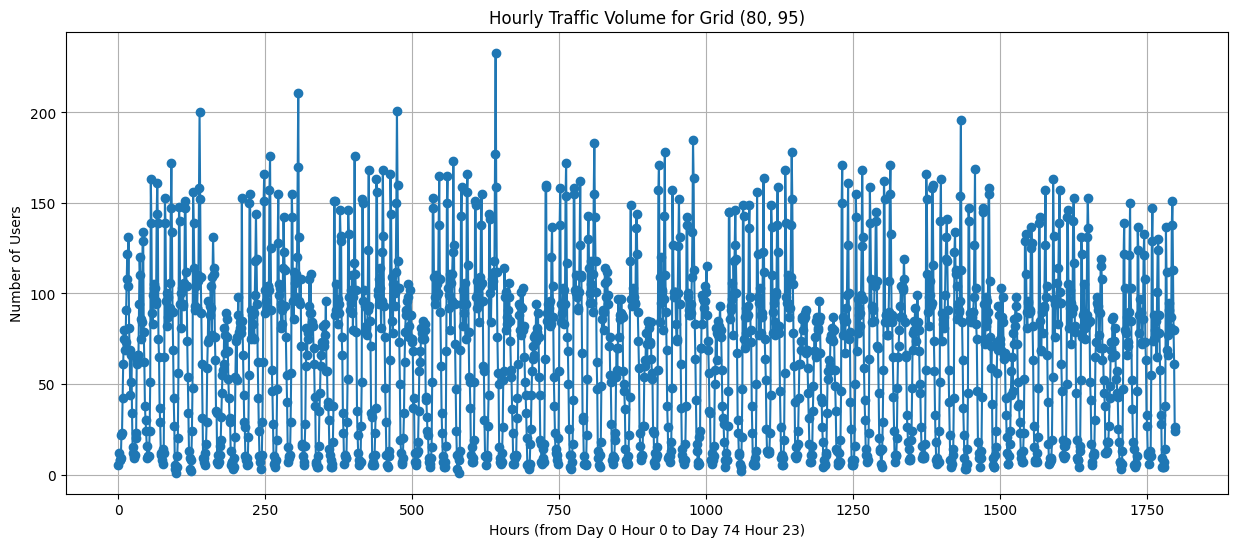

In [20]:
# 過濾出 x=80, y=95 的資料
filtered_data = data[(data['x'] == 80) & (data['y'] == 95)]

# 將時間 t 轉換為小時（t=0-47 每半小時記錄一次，所以乘以 0.5）
filtered_data['hours'] = filtered_data['d'] * 24 + (filtered_data['t'] // 2)
# 根據小時排序資料
filtered_data = filtered_data.sort_values(by='hours')

# 統計每小時的人數
hourly_counts = filtered_data.groupby('hours').size().reset_index(name='count')
# 保存結果
hourly_counts.to_csv('x=80y=95.csv', index=False)

# 繪製時間與人流量的關係圖
plt.figure(figsize=(15, 6))
plt.plot(hourly_counts['hours'], hourly_counts['count'], marker='o', linestyle='-')
plt.title('Hourly Traffic Volume for Grid (80, 95)')
plt.xlabel('Hours (from Day 0 Hour 0 to Day 74 Hour 23)')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()


第二步：預測人流量

Epoch 1/100


/var/folders/n2/fm6sdglj7ys6t3b8yg12ybwr0000gn/T/ipykernel_29702/2077834129.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['weekday'] = filtered_data['d'] % 7  # 取模7得到星期
/var/folders/n2/fm6sdglj7ys6t3b8yg12ybwr0000gn/T/ipykernel_29702/2077834129.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour_of_day'] = filtered_data['t'] // 2  # 小時


45/45 [==============================] - 0s 3ms/step - loss: 0.0397 - mae: 0.1545 - val_loss: 0.0243 - val_mae: 0.1159
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.0284 - mae: 0.1267 - val_loss: 0.0204 - val_mae: 0.1073
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.0255 - mae: 0.1206 - val_loss: 0.0183 - val_mae: 0.1025
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.0209 - mae: 0.1065 - val_loss: 0.0157 - val_mae: 0.0964
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 0.0185 - mae: 0.0957 - val_loss: 0.0134 - val_mae: 0.0889
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.0166 - mae: 0.0891 - val_loss: 0.0116 - val_mae: 0.0819
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.0164 - mae: 0.0893 - val_loss: 0.0123 - val_mae: 0.0854
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.0144 - mae: 0.0838 -

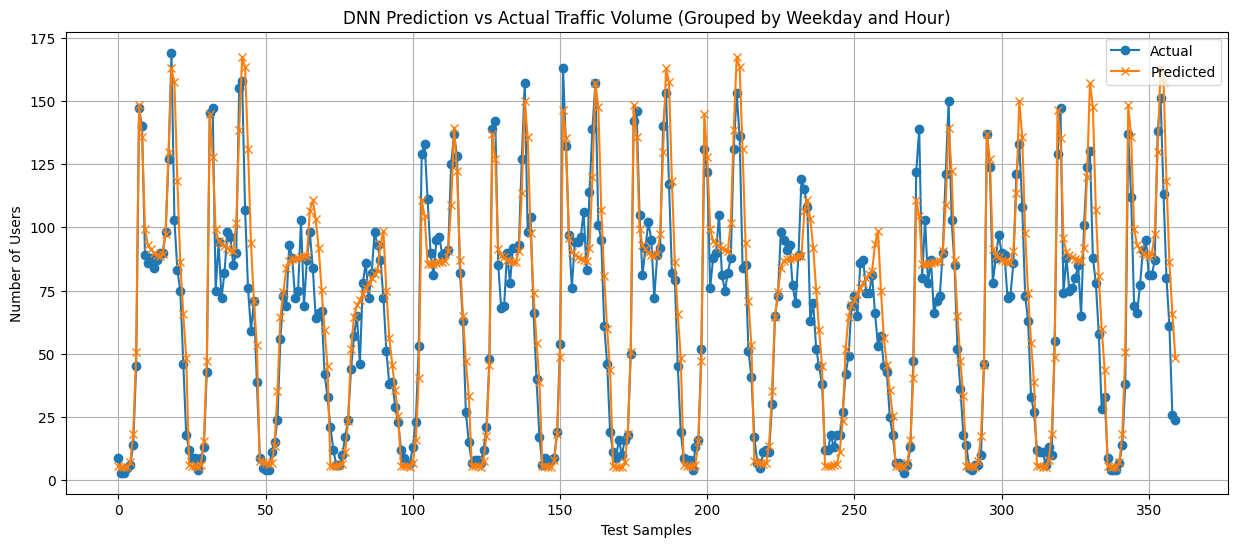

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# 讀取資料
data = pd.read_csv('city_challengedata.csv')  # 確保資料檔案正確
# 過濾 x=80, y=95 的資料
filtered_data = data[(data['x'] == 80) & (data['y'] == 95)]

# 計算星期與時間 (0:星期一 ~ 6:星期日)
filtered_data['weekday'] = filtered_data['d'] % 7  # 取模7得到星期
filtered_data['hour_of_day'] = filtered_data['t'] // 2  # 小時

# 根據星期與時間分組，統計每組人數
grouped_data = filtered_data.groupby(['d', 'weekday', 'hour_of_day']).size().reset_index(name='count')

# 切割資料集：前 60 天為訓練集，後 20 天為驗證集
train_data = grouped_data[grouped_data['d'] <= 59]  # 前 60 天的資料
val_data = grouped_data[grouped_data['d'] > 59]     # 後 20 天的資料

# 整理輸入特徵與標籤
X_train = train_data[['weekday', 'hour_of_day']].values  # 特徵：星期與小時
y_train = train_data['count'].values.reshape(-1, 1)      # 標籤：人數

X_val = val_data[['weekday', 'hour_of_day']].values      # 驗證集特徵
y_val = val_data['count'].values.reshape(-1, 1)         # 驗證集標籤

# 標準化資料
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_val_scaled = scaler_x.transform(X_val)  # 使用相同的縮放器進行驗證集標準化
y_val_scaled = scaler_y.transform(y_val)

# 建立 DNN 模型
model = Sequential()
model.add(Dense(64, input_dim=2, activation='relu'))  # 2 維特徵輸入
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # 預測單一輸出

# 編譯模型
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 訓練模型
history = model.fit(X_train_scaled, y_train_scaled, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val_scaled, y_val_scaled))

# 預測驗證集
y_pred_scaled = model.predict(X_val_scaled)
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_val_rescaled = scaler_y.inverse_transform(y_val_scaled)

# 繪製預測與實際值比較圖
plt.figure(figsize=(15, 6))
plt.plot(y_val_rescaled, label='Actual', marker='o')
plt.plot(y_pred_rescaled, label='Predicted', marker='x')
plt.title('DNN Prediction vs Actual Traffic Volume (Grouped by Weekday and Hour)')
plt.xlabel('Test Samples')
plt.ylabel('Number of Users')
plt.legend()
plt.grid(True)
plt.show()
